# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp
import sys

import rapids_singlecell.scanpy_gpu_funcs as rsf
from rapids_singlecell.cunnData import cunnData

import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5




In [2]:
import rmm
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.58 s, sys: 95.6 ms, total: 2.68 s
Wall time: 2.67 s


In [5]:
adata.shape

(93575, 33694)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

In [6]:
%%time
cudata = cunnData(adata=adata)

CPU times: user 1.23 s, sys: 637 ms, total: 1.86 s
Wall time: 1.86 s


Verify the shape of the resulting sparse matrix:

In [7]:
cudata.shape

(93575, 33694)

And the number of non-zero values in the matrix:

In [8]:
cudata.nnz

114212920

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 4.563773155212402


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
cudata.flag_gene_family(gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 7.97 ms, sys: 0 ns, total: 7.97 ms
Wall time: 7.74 ms


In [12]:
%%time
cudata.flag_gene_family(gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 5.67 ms, sys: 190 µs, total: 5.86 ms
Wall time: 5.69 ms


In [13]:
%%time
cudata.caluclate_qc(qc_vars=["MT","RIBO"])

CPU times: user 241 ms, sys: 59.6 ms, total: 300 ms
Wall time: 298 ms


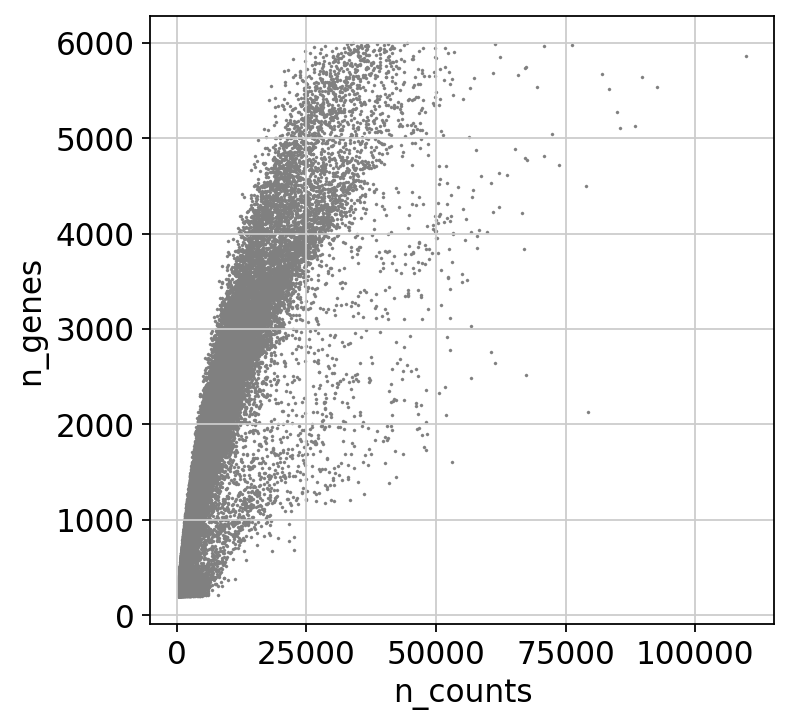

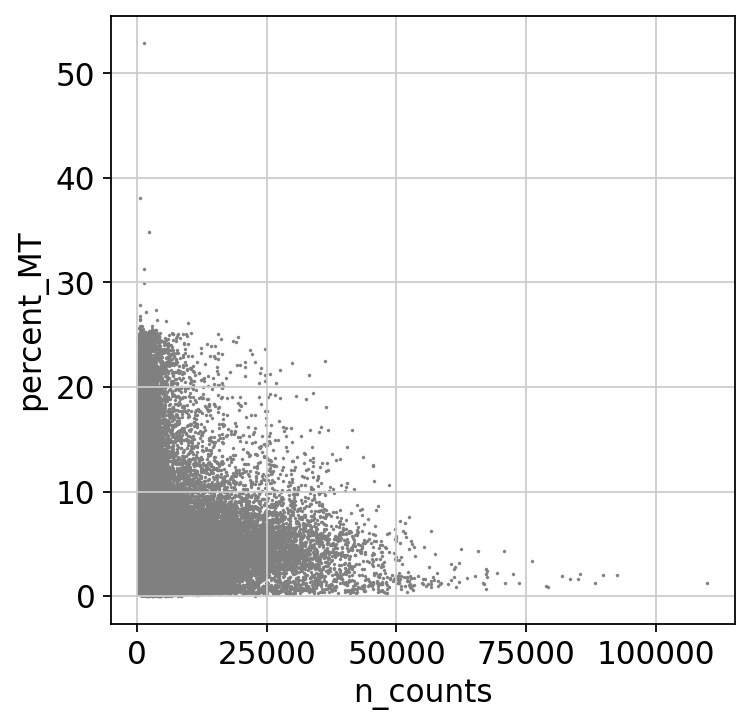

In [14]:
rsf.plt_scatter(cudata,"n_counts","n_genes")
rsf.plt_scatter(cudata,"n_counts","percent_MT")

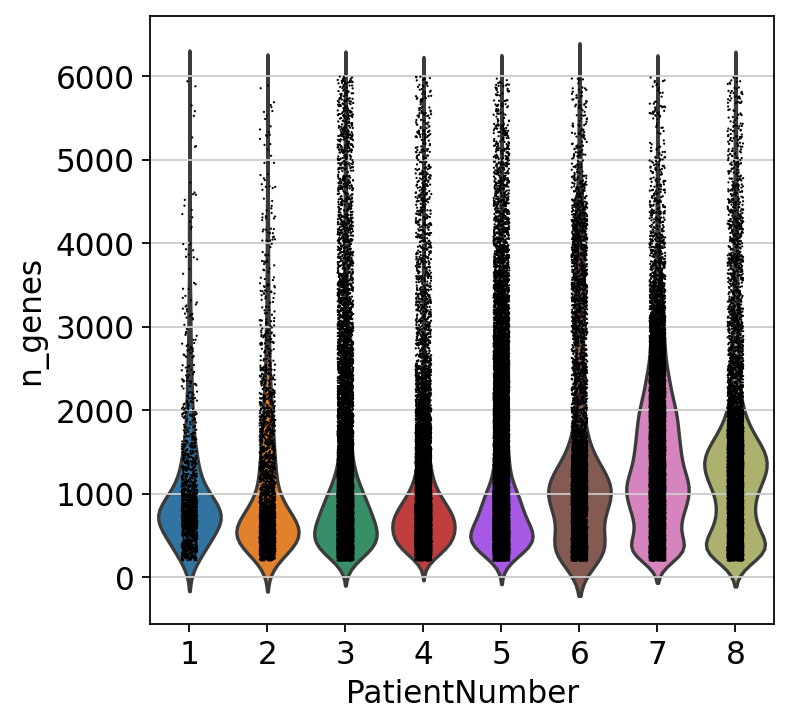

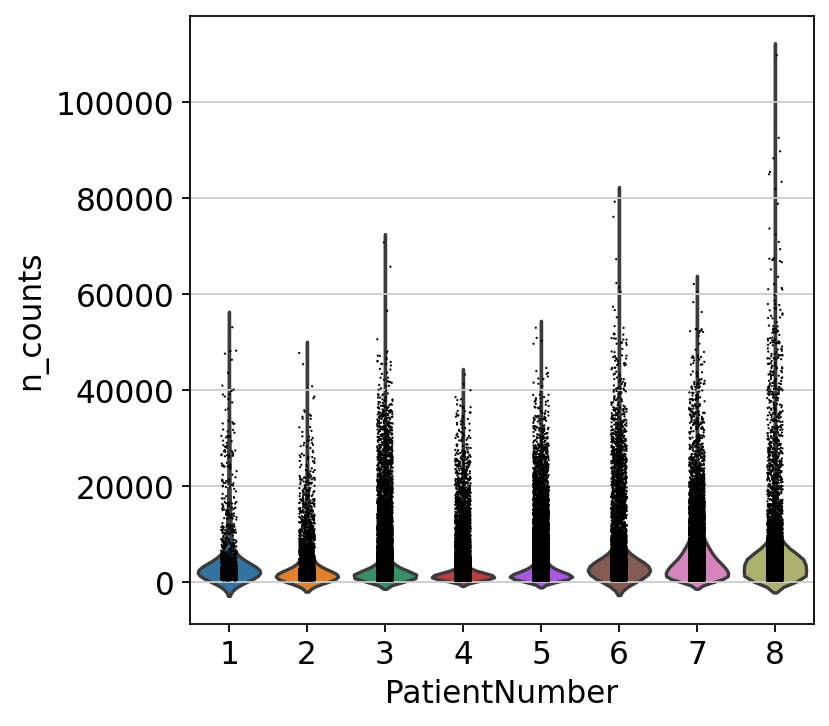

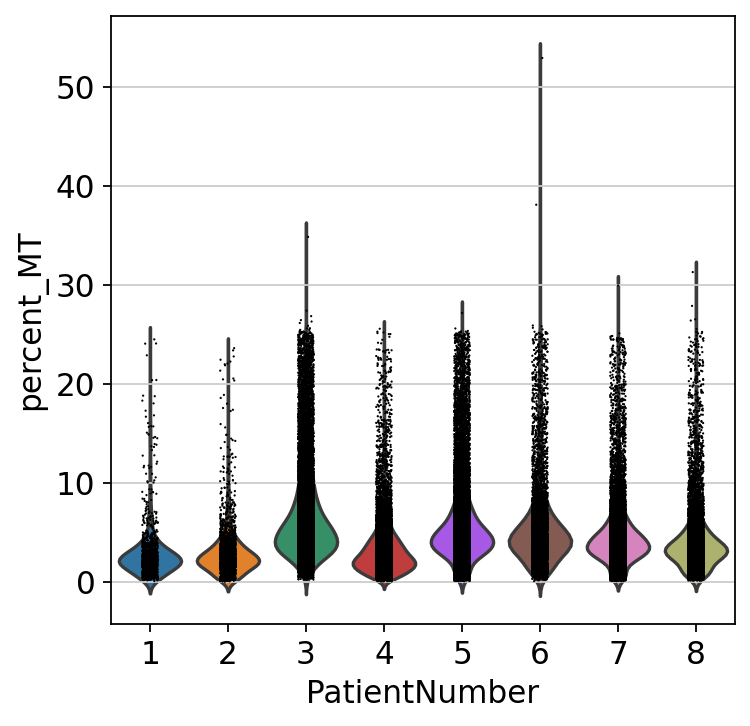

In [15]:
rsf.plt_violin(cudata,key="n_genes",groupby="PatientNumber")
rsf.plt_violin(cudata,key="n_counts",groupby="PatientNumber")
rsf.plt_violin(cudata,key="percent_MT",groupby="PatientNumber")

We store the raw expression counts in the `.layer["counts"]`

In [16]:
cudata.layers["counts"] = cudata.X.copy()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [17]:
%%time
cudata = cudata[cudata.obs["n_genes"] < 5000]
cudata = cudata[cudata.obs["percent_MT"] < 20]

CPU times: user 16.3 ms, sys: 36.6 ms, total: 52.9 ms
Wall time: 51.7 ms


We also filter out genes that are expressed in less than 3 cells.

In [18]:
%%time
cudata.filter_genes(min_count=3)

filtered out 8034 genes based on n_cells
CPU times: user 65 ms, sys: 26.3 ms, total: 91.3 ms
Wall time: 90.3 ms


In [19]:
cudata.shape

(91068, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [20]:
%%time
cudata.normalize_total(target_sum=1e4)

CPU times: user 612 µs, sys: 1.29 ms, total: 1.9 ms
Wall time: 1.19 ms


Next, we log transform the count matrix.

In [21]:
%%time
cudata.log1p()

CPU times: user 4.17 ms, sys: 371 µs, total: 4.54 ms
Wall time: 3.41 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [22]:
%%time
cudata.highly_varible_genes(n_top_genes=5000,flavor="seurat_v3",batch_key= "PatientNumber",layer = "counts")

CPU times: user 1.59 s, sys: 3.24 s, total: 4.84 s
Wall time: 549 ms


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [23]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 268 ms, sys: 101 ms, total: 369 ms
Wall time: 368 ms


Now we restrict our cunndata object to the highly variable genes.

In [24]:
%%time
cudata.filter_highly_variable()

CPU times: user 39.8 ms, sys: 7.65 ms, total: 47.4 ms
Wall time: 46.2 ms


In [25]:
cudata.shape

(91068, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [26]:
%%time
cudata.regress_out(keys=["n_counts", "percent_MT"])

CPU times: user 8.06 s, sys: 4.75 s, total: 12.8 s
Wall time: 12.8 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [27]:
%%time
cudata.scale(max_value=10)

CPU times: user 104 ms, sys: 8.15 ms, total: 112 ms
Wall time: 111 ms


Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [28]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 365 ms, sys: 142 ms, total: 506 ms
Wall time: 504 ms


In [29]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 17.289419651031494


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `scanpy_gpu_funcs` that uses cuMLs PCA to run this.

In [30]:
%%time
rsf.pca(adata, n_comps = 100)

CPU times: user 1.07 s, sys: 512 ms, total: 1.58 s
Wall time: 1.58 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

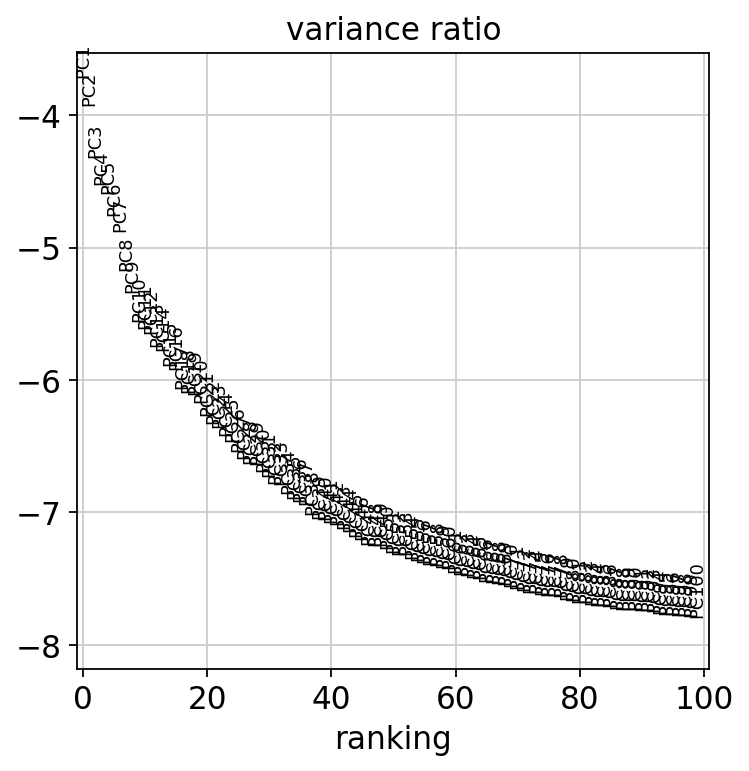

In [31]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [32]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, method='rapids')

CPU times: user 4.99 s, sys: 526 ms, total: 5.52 s
Wall time: 4.97 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [33]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 426 ms, sys: 23.1 ms, total: 450 ms
Wall time: 448 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering. As of the time of writing this notebook there is a known small bug in scanpy. The resoltion parameter of Louvain is not correctly passed to the cugraph funciton. This results in the resoltion beeing looked at 1.0.
Since the bug is fixed you can use `scanpy_gpu_funcs` implementation of Louvain.
Leiden clustering using Rapids has not been implemented in scanpy. You can also use `scanpy_gpu_funcs` implementation of the Leiden algorithm.

In [34]:
%%time
rsf.louvain(adata, resolution=0.6)
#sc.tl.louvain(adata,flavor="rapids")

CPU times: user 104 ms, sys: 8.31 ms, total: 113 ms
Wall time: 111 ms


In [35]:
%%time
rsf.leiden(adata,resolution=0.6)

CPU times: user 117 ms, sys: 839 µs, total: 117 ms
Wall time: 116 ms


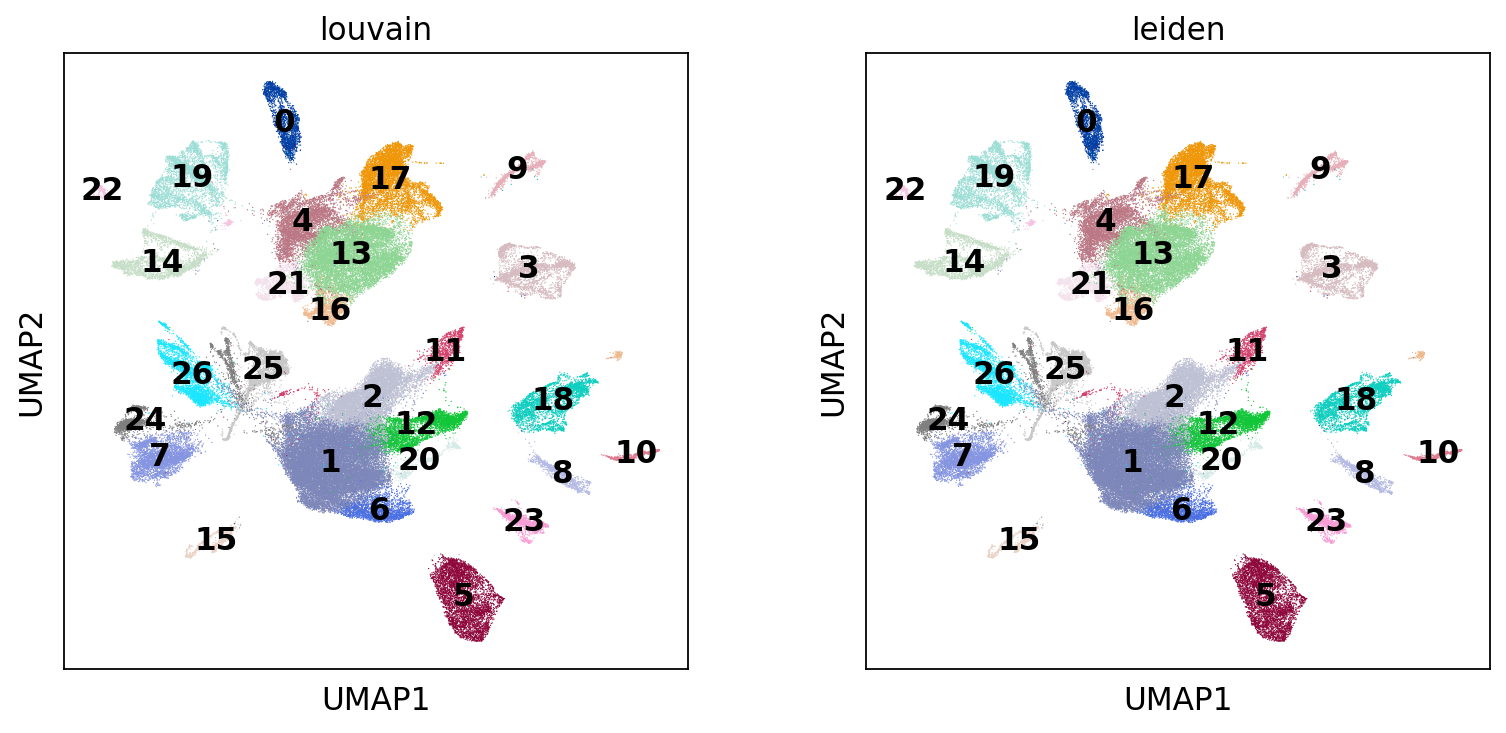

CPU times: user 765 ms, sys: 145 ms, total: 910 ms
Wall time: 716 ms


In [36]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

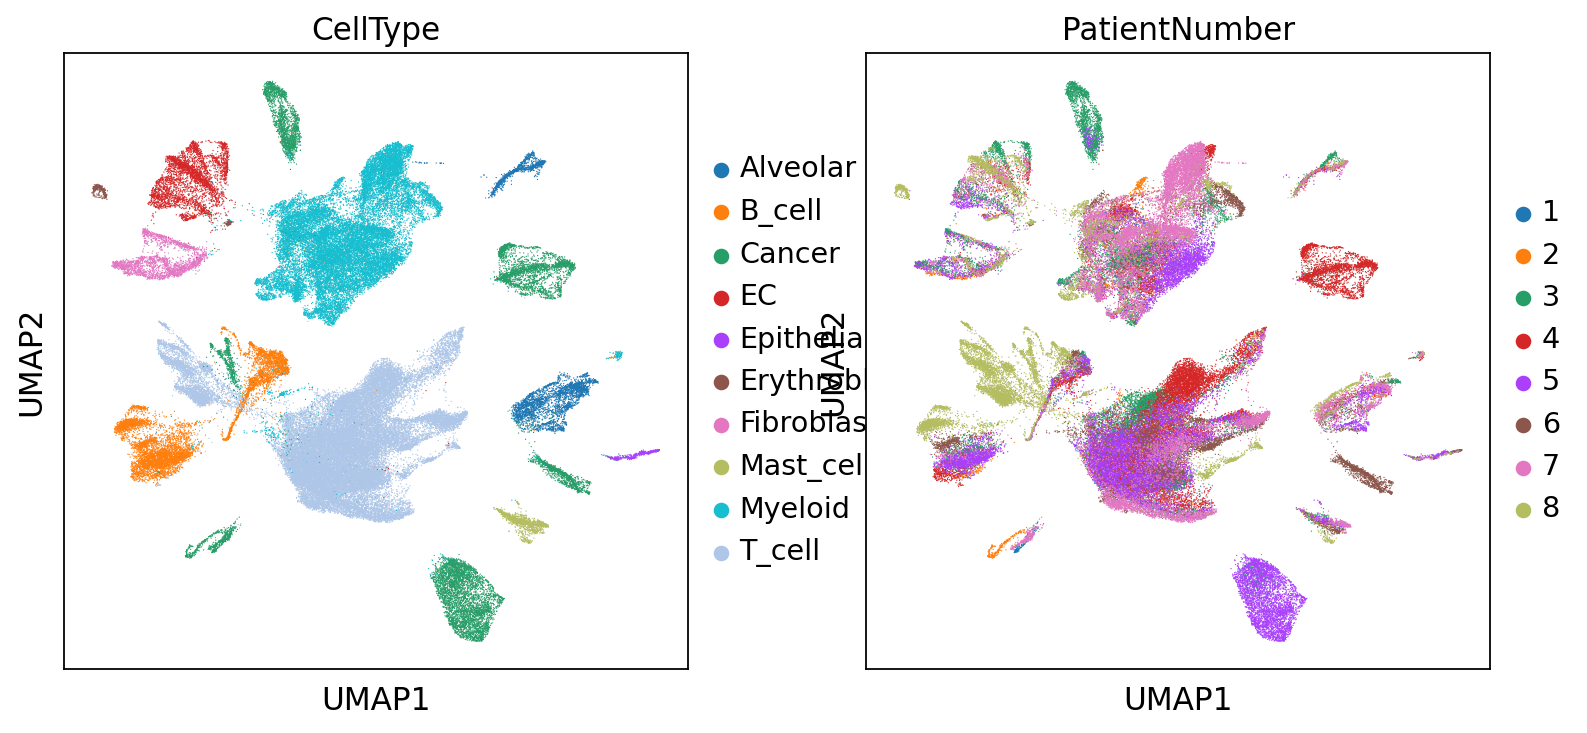

In [37]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

We also caluclate the embedding density in the UMAP using cuML

In [38]:
%%time
rsf.embedding_density(adata, groupby="PatientNumber")

CPU times: user 500 ms, sys: 75.3 ms, total: 575 ms
Wall time: 573 ms


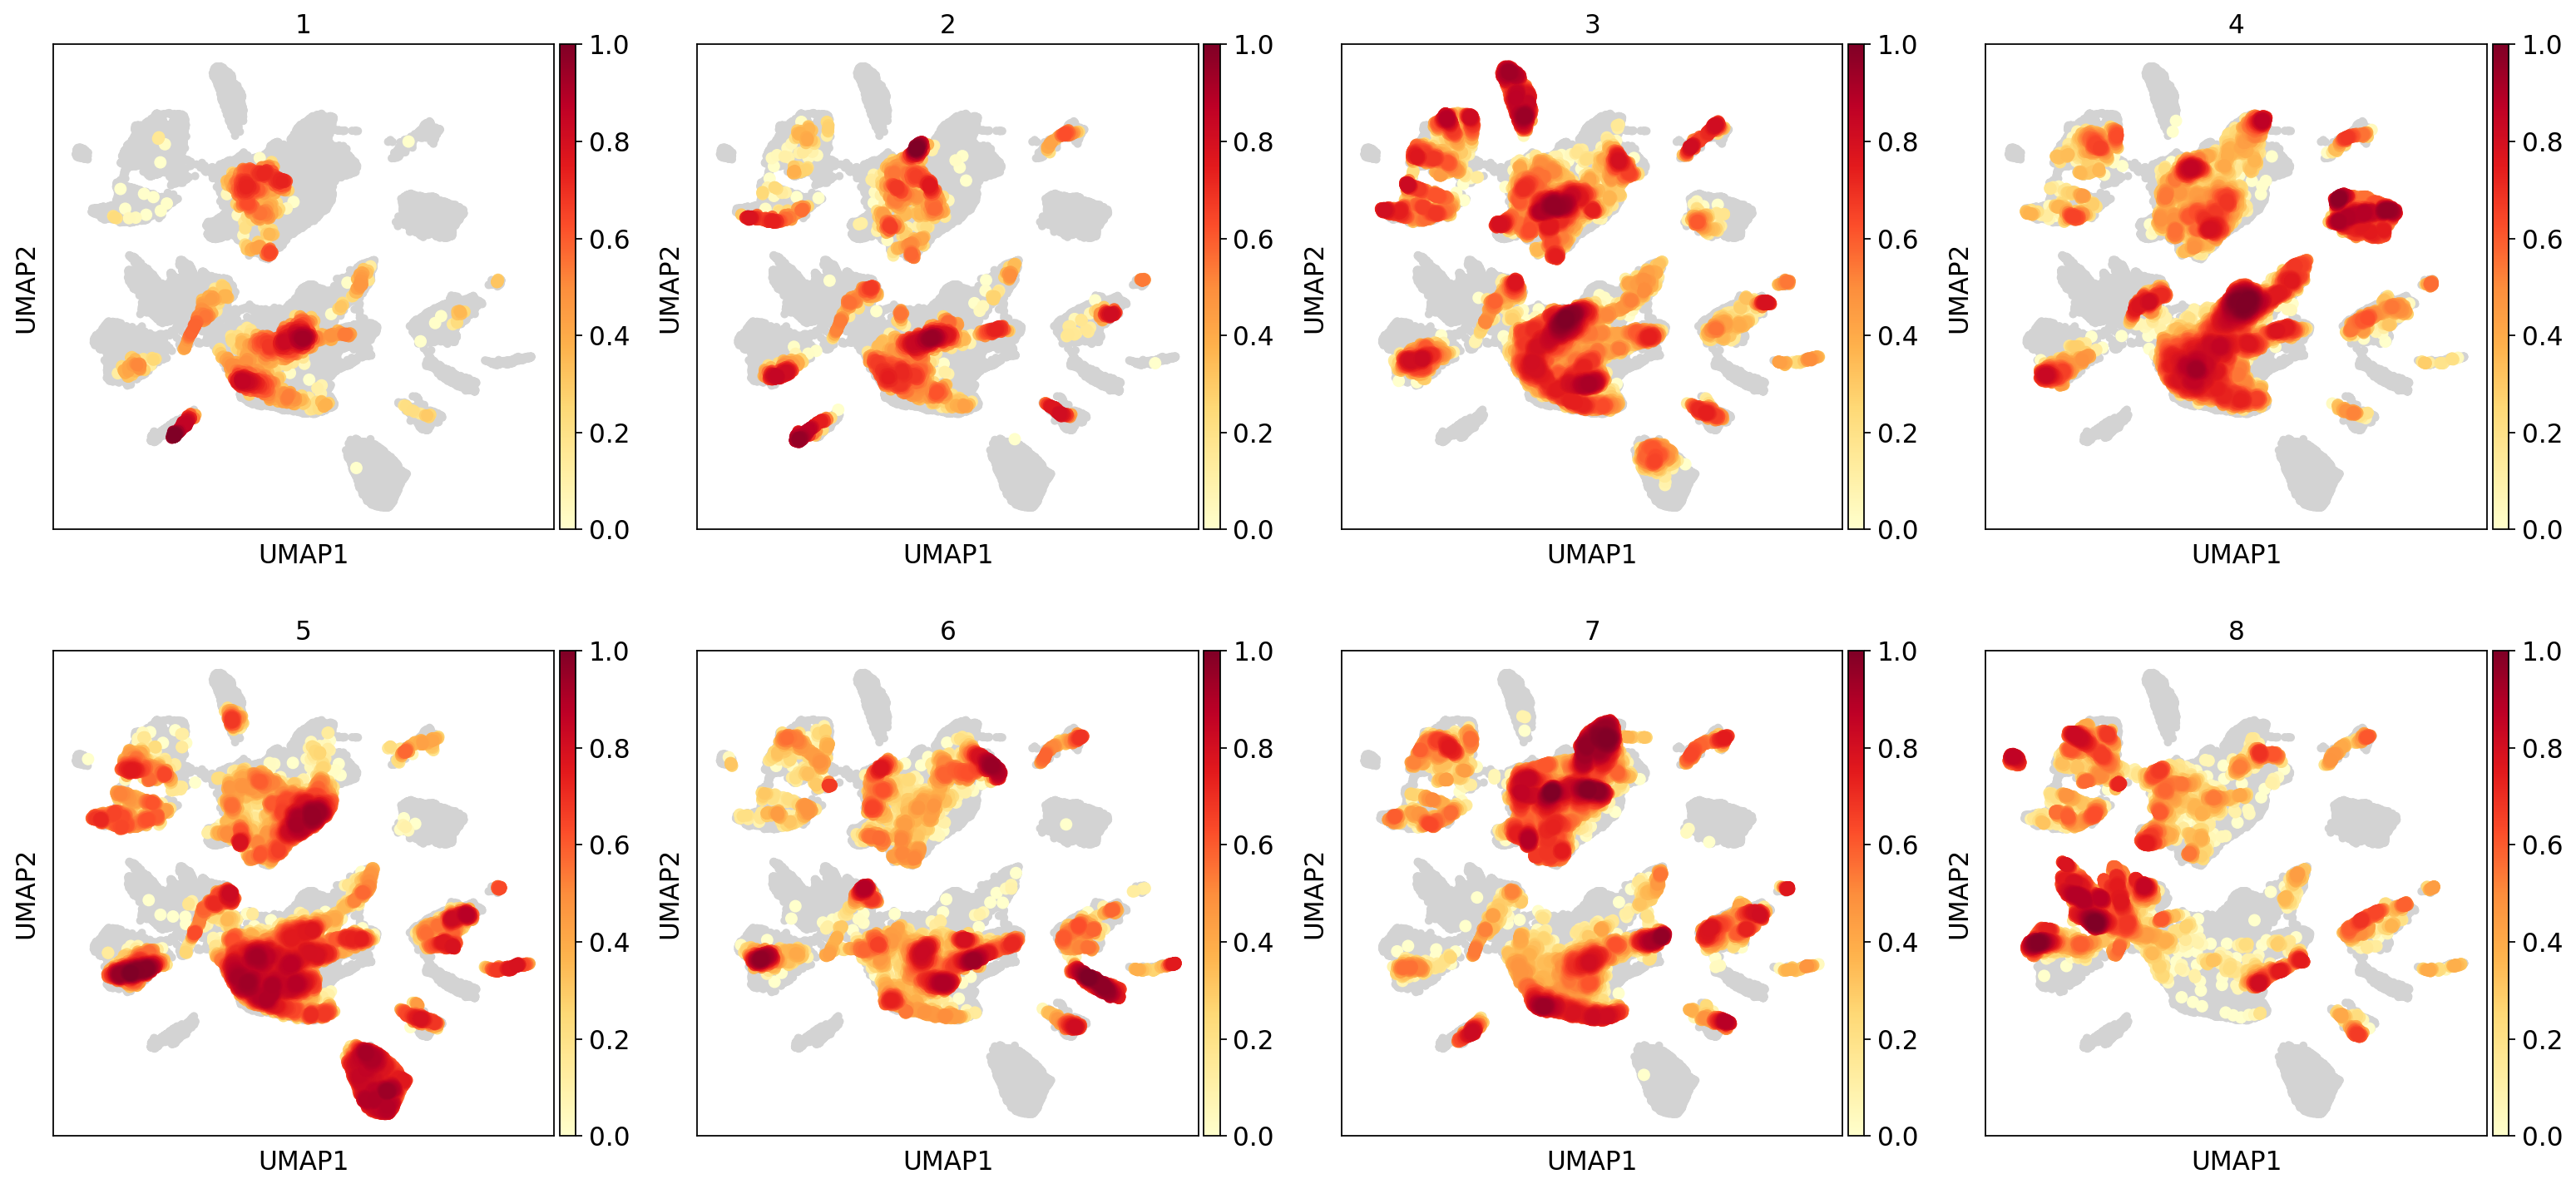

In [39]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [40]:
%%time
rsf.tsne(adata, n_pcs = 40,perplexity=30,early_exaggeration=12, learning_rate=200)

/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [12:21:32.240343] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.33 s, sys: 29.3 ms, total: 1.36 s
Wall time: 1.35 s


In [41]:
rsf.kmeans(adata, n_clusters=8)

/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


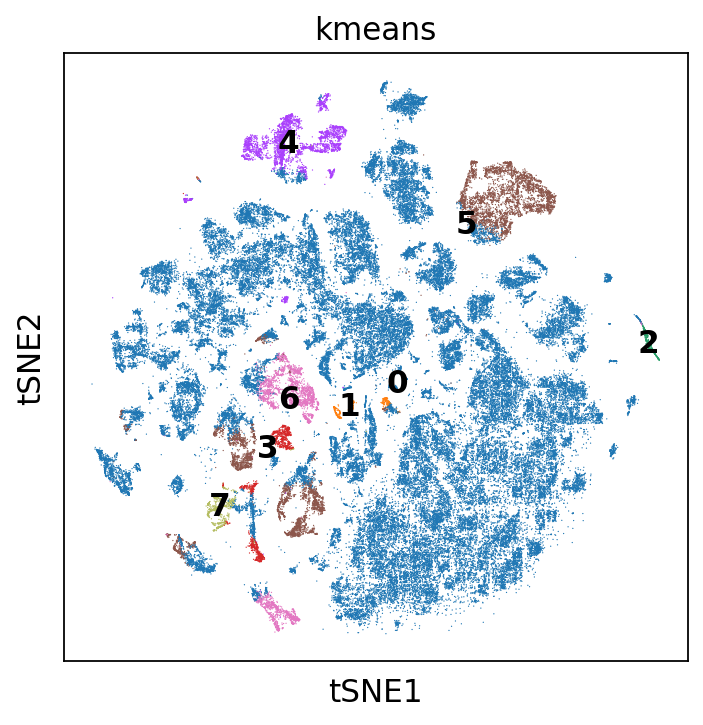

CPU times: user 423 ms, sys: 166 ms, total: 589 ms
Wall time: 395 ms


In [42]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

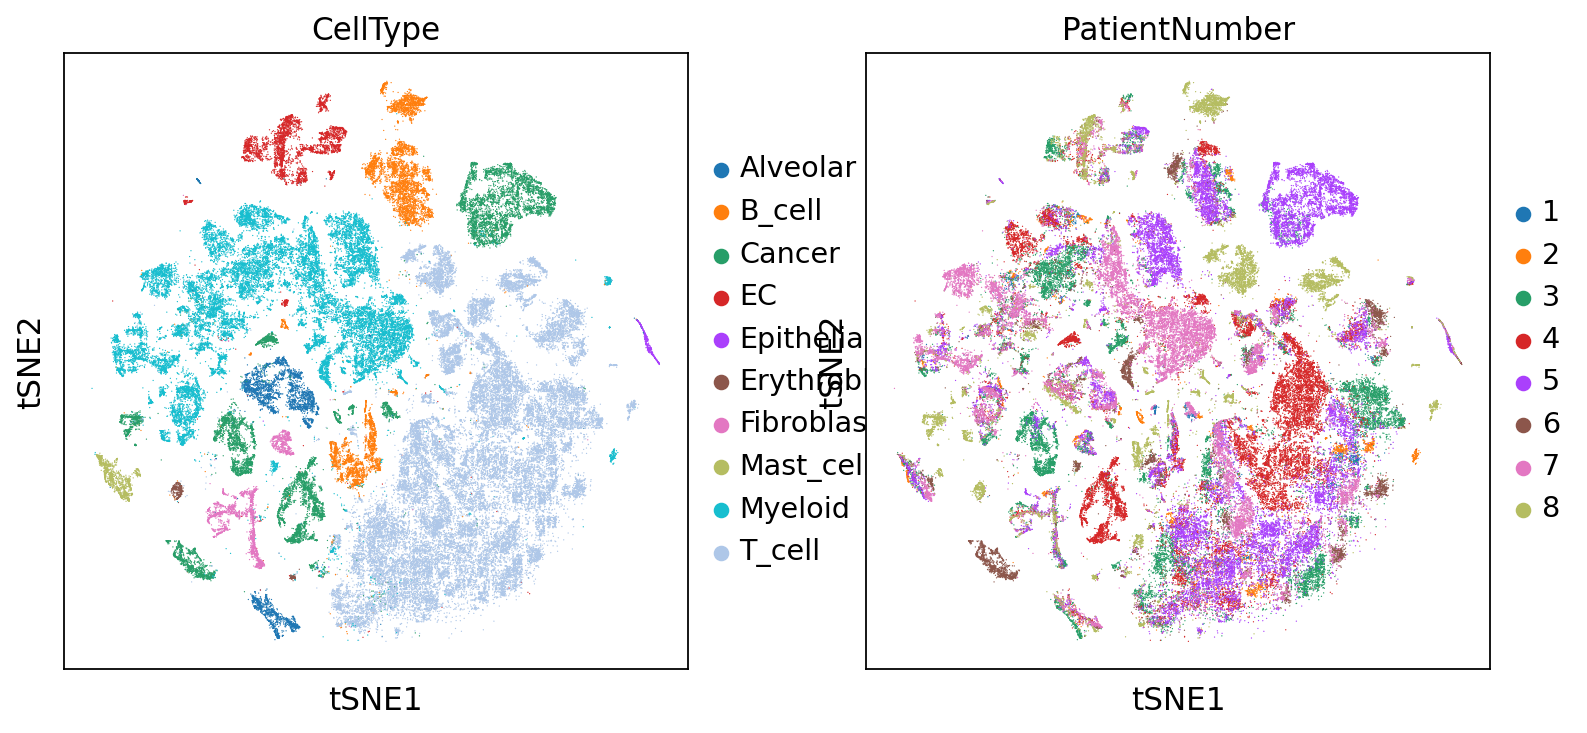

In [43]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [44]:
%%time
rsf.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

[W] [12:21:37.861801] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
CPU times: user 2.53 s, sys: 433 ms, total: 2.96 s
Wall time: 2.95 s


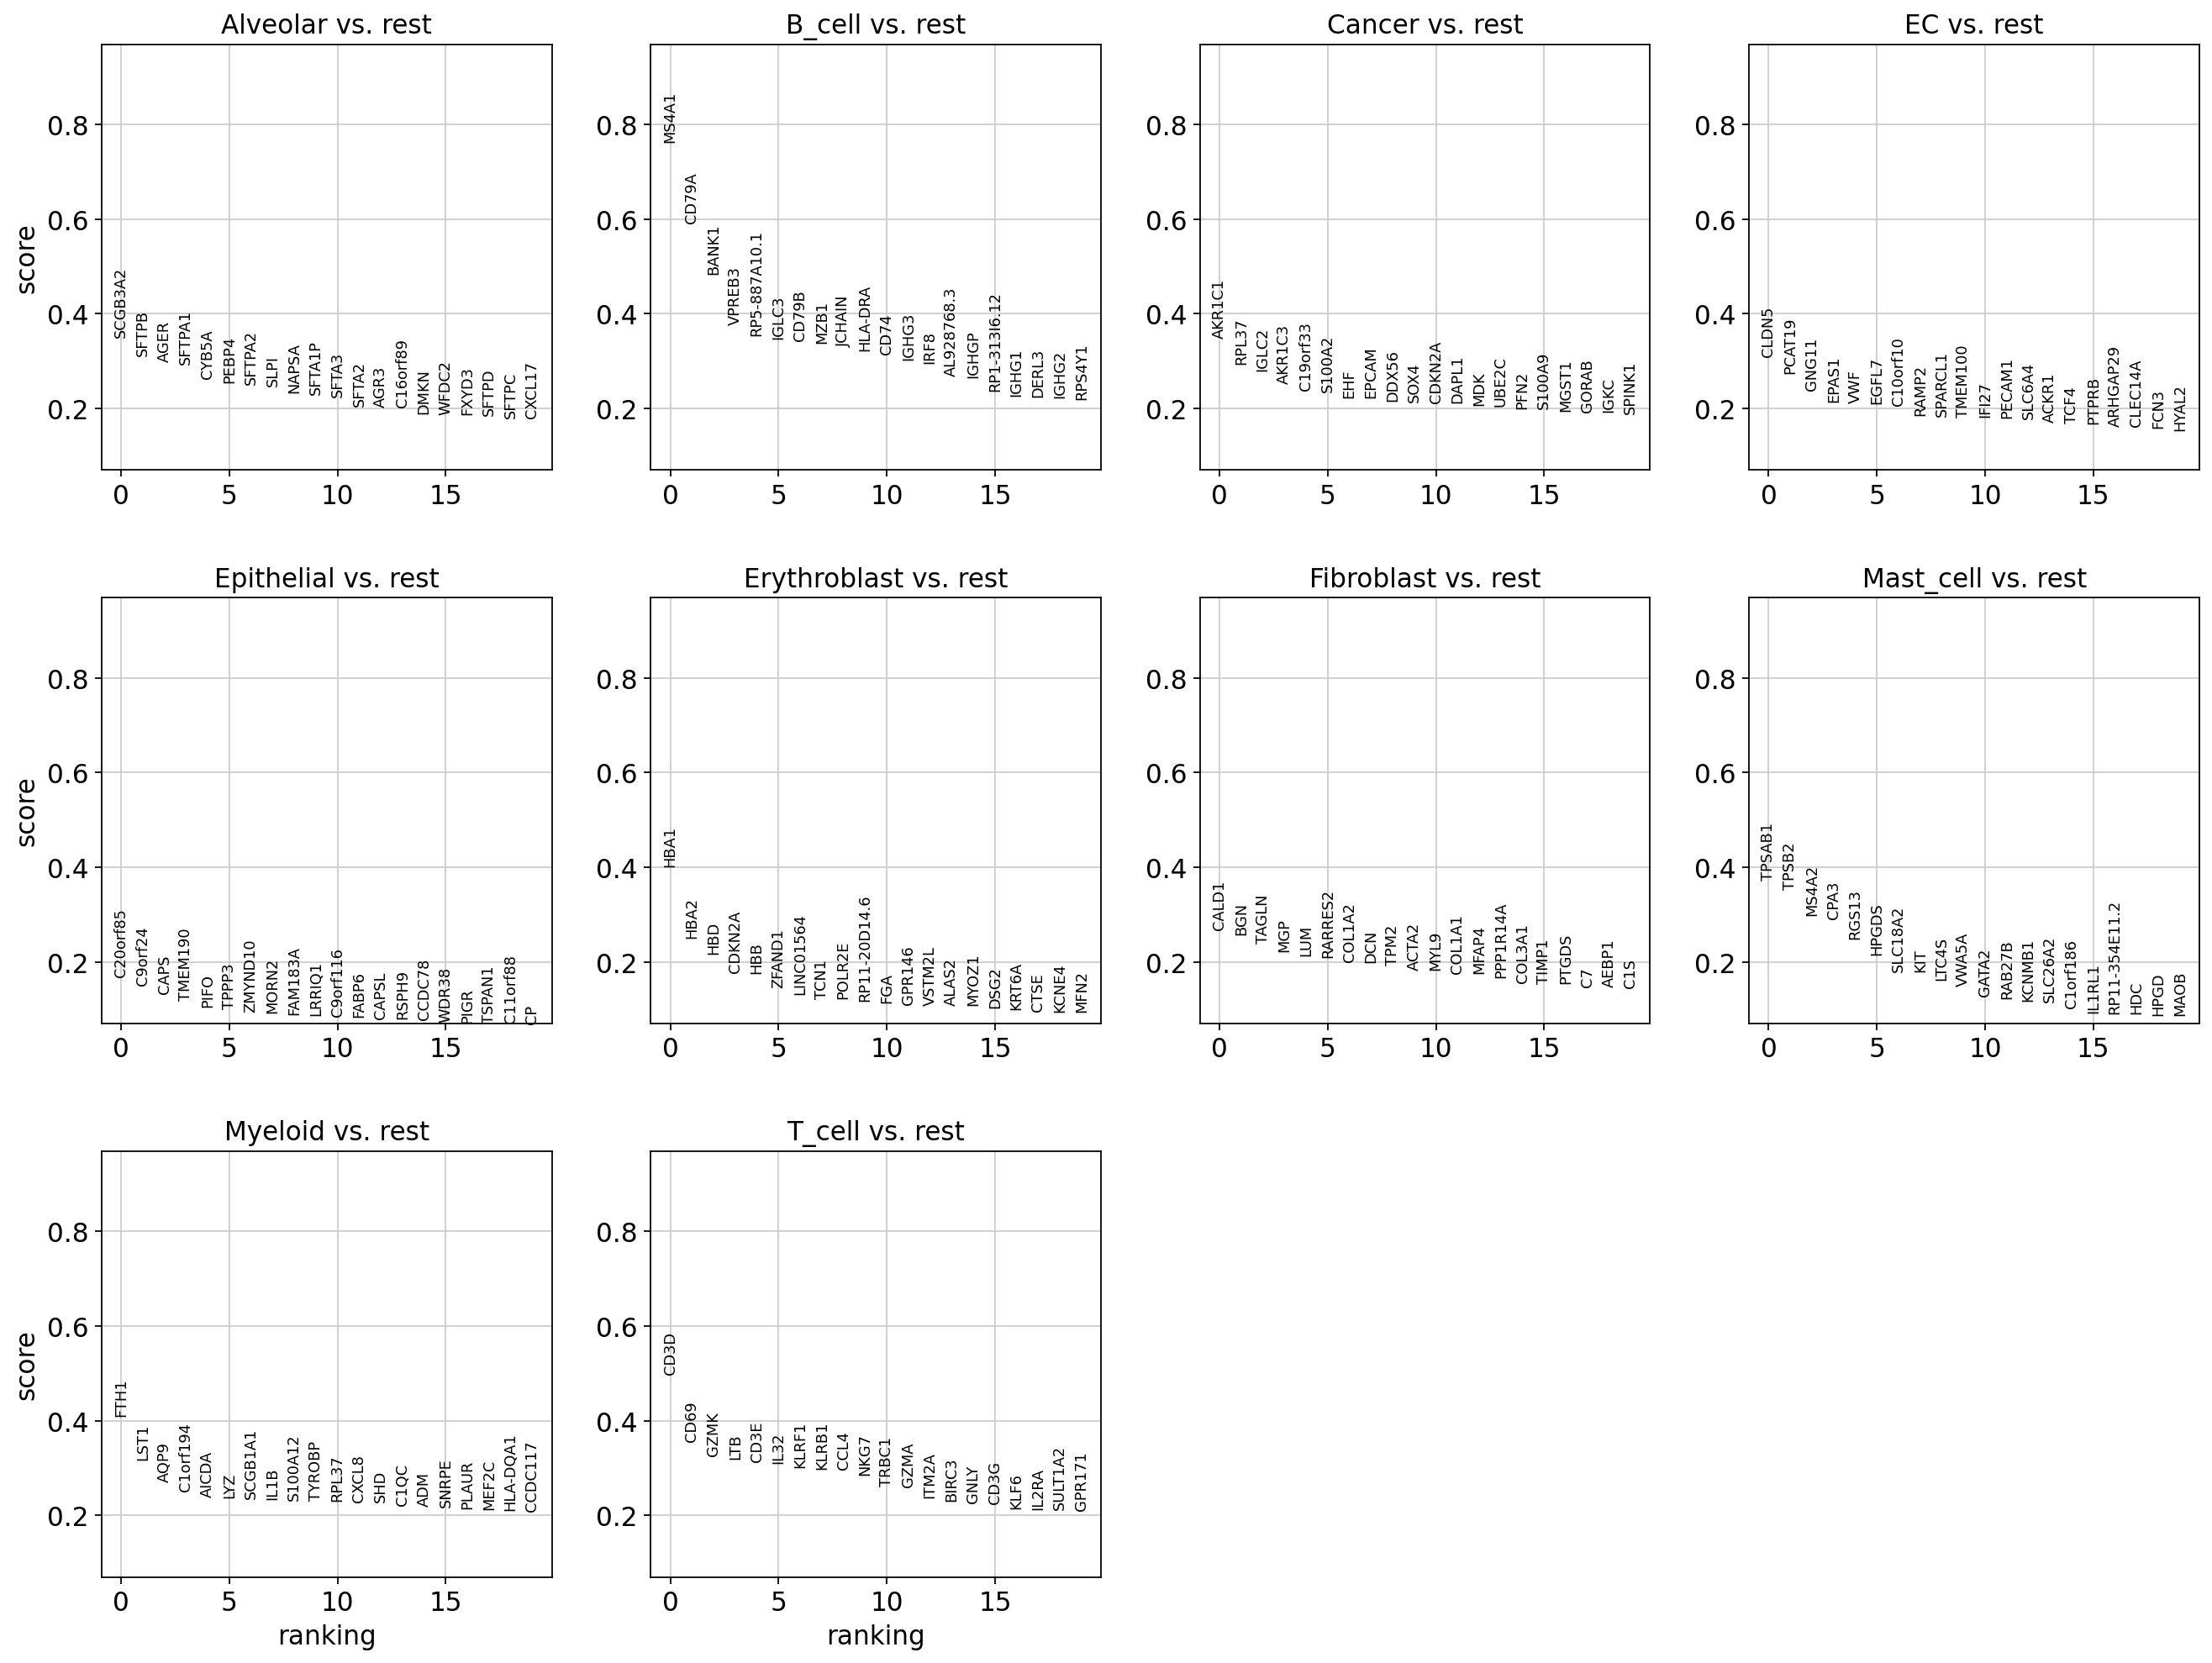

CPU times: user 1.15 s, sys: 258 ms, total: 1.41 s
Wall time: 1.12 s


In [45]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [46]:
post_time = time.time()

In [47]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 19.620811700820923


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [48]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

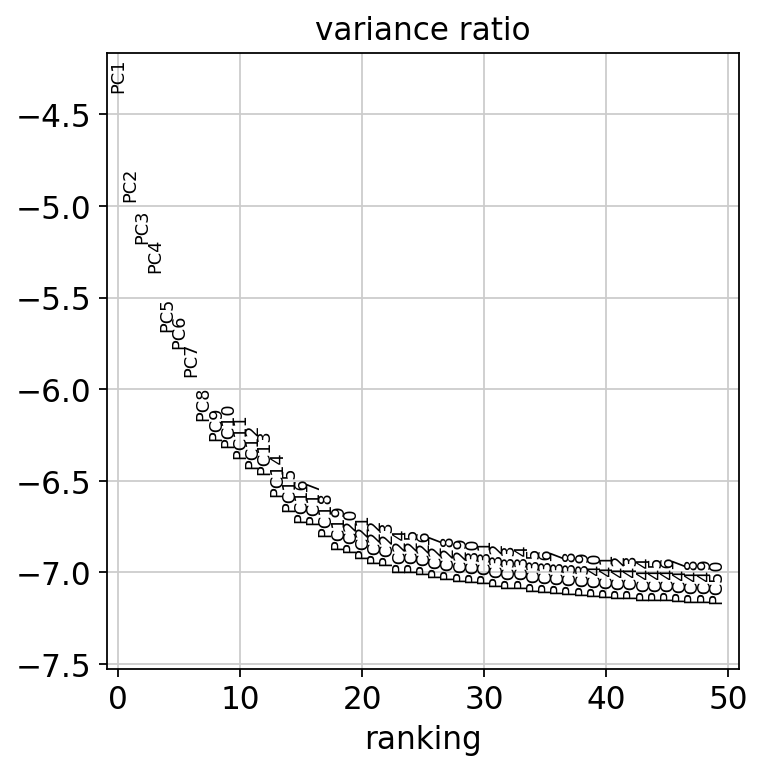

CPU times: user 849 ms, sys: 446 ms, total: 1.3 s
Wall time: 1.08 s


In [49]:
%%time
rsf.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [50]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20, method='rapids')
sc.tl.umap(tdata, method='rapids')
rsf.louvain(tdata)

CPU times: user 1.04 s, sys: 125 ms, total: 1.16 s
Wall time: 899 ms


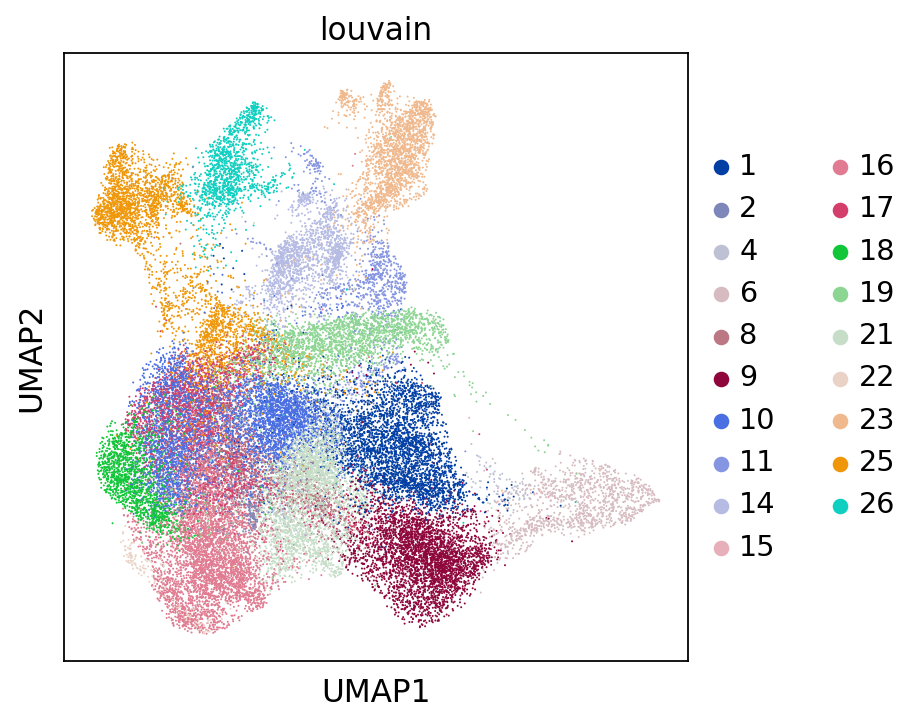

In [51]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [52]:
%%time
rsf.diffmap(tdata)

CPU times: user 527 ms, sys: 1.61 s, total: 2.14 s
Wall time: 212 ms


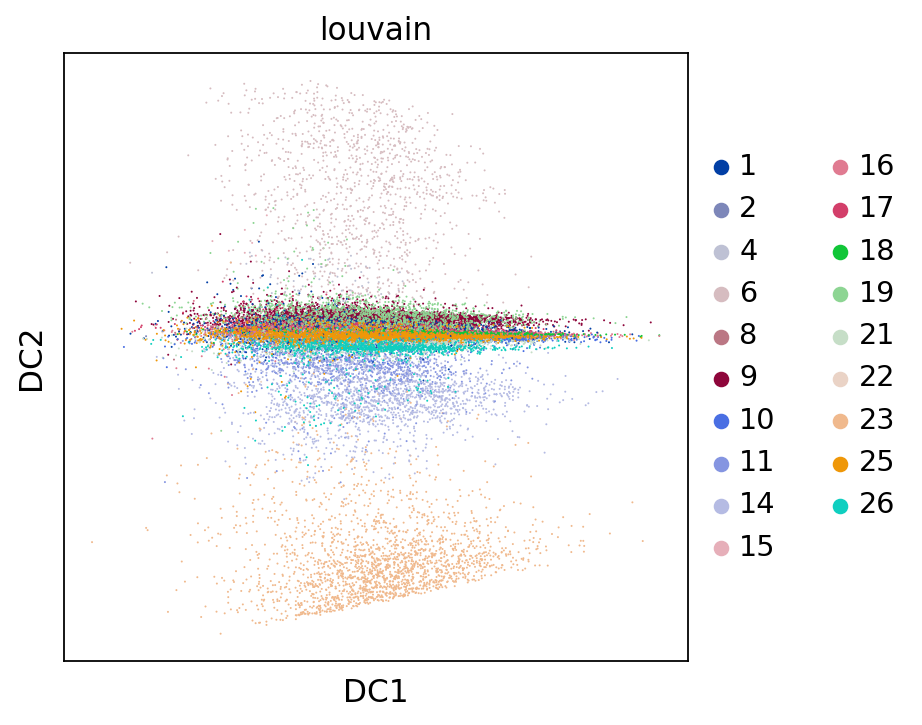

In [53]:
sc.pl.diffmap(tdata, color='louvain')

In [54]:
%%time
rsf.draw_graph(tdata)

CPU times: user 345 ms, sys: 369 µs, total: 345 ms
Wall time: 344 ms


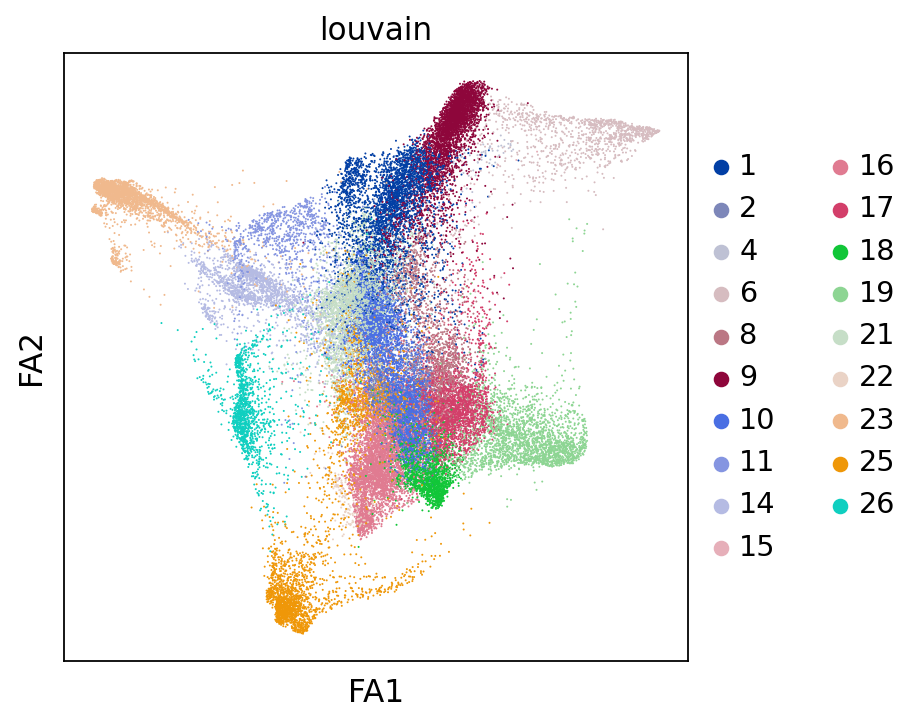

In [55]:
sc.pl.draw_graph(tdata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [56]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 40.90978264808655
